# Case study 1: Stochastic volatility

see: http://docs.pymc.io/notebooks/getting_started.html#Case-study-1:-Stochastic-volatility

## Import libraries

In [7]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
from pandas_datareader import data

import pymc3 as pm
from scipy import optimize

import warnings
warnings.filterwarnings('ignore')

## The Model

$$\sigma \sim \mathcal{exp}(50)$$

$$\nu \sim \mathcal{exp}(.1)$$

$$\mathcal{s_i} \sim \mathcal{N}(s_{i-1}, \sigma^{-2})$$

$$\mathcal{log}(y_i) \sim \mathcal{t}(\nu, 0, \mathcal{exp}(-2\mathcal{s_i}))$$

## The Data

In [16]:
returns = data.get_data_yahoo('SPY', start='2008-5-1', end='2009-12-1')['Close'].pct_change()

len(returns)

402

In [14]:
returns.head()

Date
2008-04-30         NaN
2008-05-01    0.020686
2008-05-02    0.002764
2008-05-05   -0.004805
2008-05-06    0.008663
Name: Close, dtype: float64

In [20]:
returns.tail()

Date
2009-11-24    0.001534
2009-11-25    0.003514
2009-11-27   -0.016251
2009-11-30    0.003377
2009-12-01    0.012370
Name: Close, dtype: float64

In [19]:
returns.describe()

count    401.000000
mean      -0.000260
std        0.023778
min       -0.098448
25%       -0.010825
50%        0.000784
75%        0.010219
max        0.145198
Name: Close, dtype: float64

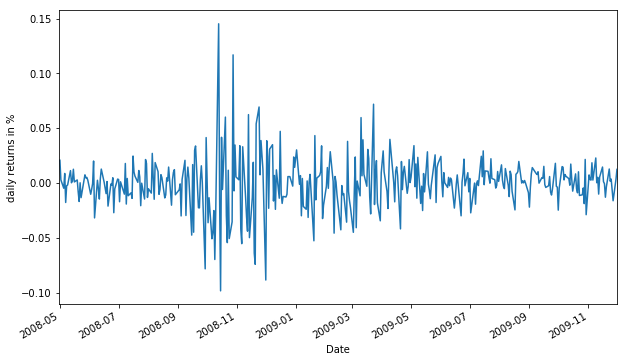

In [12]:
returns.plot(figsize=(10, 6))
plt.ylabel('daily returns in %')

## Model specification

In [21]:
with pm.Model() as sp500_model:
    nu = pm.Exponential('nu', 1./10, testval=5.)
    sigma = pm.Exponential('sigma', 1./.02, testval=.1)
    
    s = pm.GaussianRandomWalk('s', sigma**-2, shape=len(returns))
    volatility_process = pm.Deterministic('volatility_process', pm.math.exp(-2*s))

    r = pm.StudentT('r', nu, lam=1/volatility_process, observed=returns)

## Model fitting

In [22]:
with sp500_model:
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2500/2500 [01:47<00:00, 23.27it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1176b4668>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11733e860>]], dtype=object)

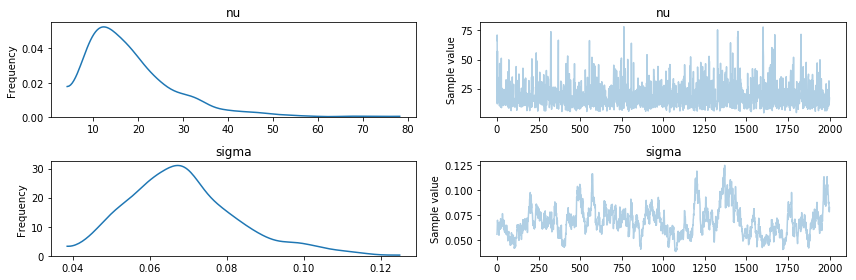

In [24]:
pm.traceplot(trace, [nu, sigma])

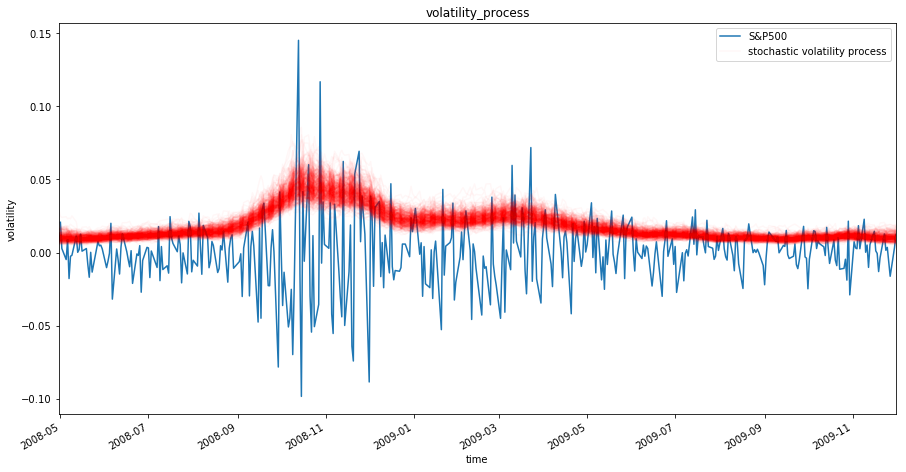

In [25]:
fig, ax = plt.subplots(figsize=(15, 8))
returns.plot(ax=ax)
ax.plot(returns.index, 1/np.exp(trace['s',::5].T), 'r', alpha=.03)
ax.set(title='volatility_process', xlabel='time', ylabel='volatility')
ax.legend(['S&P500', 'stochastic volatility process'])